In [15]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import tensorflow as tf
import cifar10
from cifar10 import num_classes
import matplotlib.pyplot as plt
import scipy
import cv2
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [16]:
train_data,train_labels,onehot_train=cifar10.load_training_data()
test_data,test_labels,onehot_test=cifar10.load_test_data()
train_data=train_data.astype('float32')
train_labels=train_labels.astype('int32')
test_data=test_data.astype('float32')
test_labels=test_labels.astype('int32')
tf.logging.set_verbosity(tf.logging.ERROR)

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
<_io.BufferedReader name='data/CIFAR-10/cifar-10-batches-py/data_batch_1'>
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
<_io.BufferedReader name='data/CIFAR-10/cifar-10-batches-py/data_batch_2'>
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
<_io.BufferedReader name='data/CIFAR-10/cifar-10-batches-py/data_batch_3'>
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
<_io.BufferedReader name='data/CIFAR-10/cifar-10-batches-py/data_batch_4'>
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
<_io.BufferedReader name='data/CIFAR-10/cifar-10-batches-py/data_batch_5'>
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch
<_io.BufferedReader name='data/CIFAR-10/cifar-10-batches-py/test_batch'>


In [17]:
weight_decay = 1e-2
regularizer = tf.contrib.layers.l2_regularizer(scale=weight_decay)
filter_size = 3
feature_maps = 96
acc_track = []

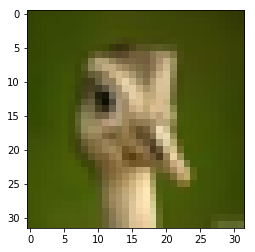

In [18]:
plt.imshow(train_data[421])

In [19]:
def Squeeze(data,f):
    
#     #Color depth reduction
    temp = np.ndarray.flatten(data)
    temp = temp*15
    temp = temp.astype(int)
    temp = temp/15
 
    #Median Smoothing
    temp = temp.reshape(-1,data.shape[1],data.shape[2],data.shape[3])
    for i in range (0,temp.shape[0]):
        temp[i] = scipy.ndimage.filters.median_filter(temp[i],size=(f,f,f))
    
    #Non-local Smoothing
    r = data.shape[0]
    r = int(r)
    for i in range (0,r): 
        y = temp[i].dot(255)
        y = y.astype(np.uint8)
        temp[i] = cv2.fastNlMeansDenoisingColored(y,None,3,3,7,21)
#         if i == 10:
#             plt.imshow(temp[i],cmap='gray')
    temp = temp.astype(np.float32)/255
    return temp

In [20]:
train_data = Squeeze(train_data,3)

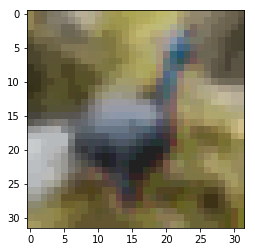

In [21]:
plt.imshow(train_data[6])

In [22]:
test_data = Squeeze(test_data,3)

In [23]:
mean = np.mean(train_data,axis=(0,1,2,3))
std = np.std(train_data,axis=(0,1,2,3))
x_train = (train_data-mean)/(std+1e-7)
x_test = (test_data-mean)/(std+1e-7)

In [24]:
def cnn_model_fn(features, labels, mode):
      input_layer = tf.reshape(features["x"], [-1, 32, 32,3])
      dropout0_1 = tf.contrib.layers.dropout(inputs=input_layer, keep_prob=0.8)  
      conv1 = tf.contrib.layers.conv2d(
          inputs = dropout0_1,
          num_outputs = feature_maps,
          kernel_size = filter_size,
          weights_regularizer=regularizer,
          )
      
      conv1_bn =  tf.contrib.layers.batch_norm(
            inputs=conv1,
            fused = True
      )
      dropout1_2 = tf.contrib.layers.dropout(inputs=conv1_bn, keep_prob=0.7)  
      conv2 = tf.contrib.layers.conv2d(
          inputs = dropout1_2,
          num_outputs = feature_maps,
          kernel_size = filter_size,
          weights_regularizer=regularizer,
          )

      conv2_bn =  tf.contrib.layers.batch_norm(
            inputs=conv2,
            fused = True
        )
      dropout2_3 = tf.contrib.layers.dropout(inputs=conv2_bn, keep_prob=0.7)

      conv3 = tf.contrib.layers.conv2d(
          inputs = dropout2_3,
          num_outputs = feature_maps,
          kernel_size = filter_size,
          weights_regularizer=regularizer,
          stride = 2
          )
      conv3_bn =  tf.contrib.layers.batch_norm(
            inputs=conv3,
            fused = True
        )
      dropout3_4 = tf.contrib.layers.dropout(inputs=conv3_bn, keep_prob=0.7)  
      conv4 = tf.contrib.layers.conv2d(
          inputs = dropout3_4,
          num_outputs = 2*feature_maps,
          kernel_size = filter_size,
          weights_regularizer=regularizer,
          )

      conv4_bn =  tf.contrib.layers.batch_norm(
            inputs=conv4,
            fused = True
        )

      
      #pool2 = tf.contrib.layers.max_pool2d(inputs = conv4_bn,kernel_size = [2,2],stride = 2)
    
      
        #dropout2 =  tf.contrib.layers.dropout(inputs=pool2, keep_prob=0.7)

      dropout4_5 = tf.contrib.layers.dropout(inputs=conv4_bn, keep_prob=0.7)
      
      conv5 = tf.contrib.layers.conv2d(
          inputs = dropout4_5,
          num_outputs = 2*feature_maps,
          kernel_size = filter_size,
          weights_regularizer=regularizer,
          )


      conv5_bn =  tf.contrib.layers.batch_norm(
            inputs=conv5,
            fused = True
        )
      dropout5_6 = tf.contrib.layers.dropout(inputs=conv5_bn, keep_prob=0.7)
      
      conv6 = tf.contrib.layers.conv2d(
          inputs = dropout5_6,
          num_outputs = 2*feature_maps,
          kernel_size = filter_size,
          weights_regularizer=regularizer,
          stride = 2
          )

      conv6_bn =  tf.contrib.layers.batch_norm(
            inputs=conv6,
            fused = True
        )

      
      #pool3 = tf.contrib.layers.max_pool2d(inputs = conv6_bn,kernel_size = [2,2] ,stride = 2)
      dropout3 =  tf.contrib.layers.dropout(inputs=conv6_bn, keep_prob=0.5)
      
#       print("**************************************")
#       print(dropout3.shape)
      pool3_flat = tf.reshape(dropout3, [-1, 8* 8* 192])
    
      logits = tf.layers.dense(inputs=pool3_flat, units=10)
      predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.contrib.layers.softmax(logits)
  }
      if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

      # Calculate Loss (for both TRAIN and EVAL modes)
      loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

      # Configure the Training Op (for TRAIN mode)
      if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

      # Add evaluation metrics (for EVAL mode)
      eval_metric_ops = {
          "accuracy": tf.metrics.accuracy(
              labels=labels, predictions=predictions["classes"]),
      }
      return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


In [25]:
def current_loss(flag):
    train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      shuffle=False)
    eval_result1=cifar_classifier.evaluate(input_fn=train_eval_input_fn)
    if flag:
        print("%%%%%%% Train accuracy %%%%%%%%%%%%\n",eval_result1)
    [a,b,c] = eval_result1.items()

    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": test_data},
      y=test_labels,
      num_epochs=1,
      shuffle=False)
    eval_result2=cifar_classifier.evaluate(input_fn=eval_input_fn)
    if flag:
        print("######### Test accuracy #############\n",eval_result2)
    [d,e,f] = eval_result2.items()
    acc_track.append([a[1],d[1]])
    return a[1],d[1]

In [26]:
# Evaluate the model and print results
cifar_classifier = tf.estimator.Estimator(
  model_fn=cnn_model_fn, model_dir="./CIFAR_10_fs")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=50)
print("started\n")
# Train the model
i = 0 
while 1:
    if i:
        curr_result = current_loss(1)
        print(curr_result)
        if curr_result[1] > 0.82:
            break
# Train the model
    print("Training")
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=256,
      num_epochs=None,
      shuffle=True)

    cifar_classifier.train(
      input_fn=train_input_fn,
      steps=1000,
      hooks=None)
    i=1
    #print(curr_result)
print ("Finished")

started

Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.33268, 'loss': 1.8055656, 'global_step': 1001}
######### Test accuracy #############
 {'accuracy': 0.3253, 'loss': 1.8128417, 'global_step': 1001}
(0.33268, 0.3253)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.3843, 'loss': 1.6922481, 'global_step': 2001}
######### Test accuracy #############
 {'accuracy': 0.3787, 'loss': 1.6936464, 'global_step': 2001}
(0.3843, 0.3787)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.40512, 'loss': 1.6349976, 'global_step': 3001}
######### Test accuracy #############
 {'accuracy': 0.3986, 'loss': 1.6473105, 'global_step': 3001}
(0.40512, 0.3986)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.42396, 'loss': 1.6032412, 'global_step': 4001}
######### Test accuracy #############
 {'accuracy': 0.4229, 'loss': 1.5994717, 'global_step': 4001}
(0.42396, 0.4229)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.41316, 'loss': 1.6442562, 'g

######### Test accuracy #############
 {'accuracy': 0.6245, 'loss': 1.1194663, 'global_step': 37001}
(0.66808, 0.6245)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.68576, 'loss': 0.9178862, 'global_step': 38001}
######### Test accuracy #############
 {'accuracy': 0.6342, 'loss': 1.0983986, 'global_step': 38001}
(0.68576, 0.6342)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.6864, 'loss': 0.90575993, 'global_step': 39001}
######### Test accuracy #############
 {'accuracy': 0.6332, 'loss': 1.107688, 'global_step': 39001}
(0.6864, 0.6332)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.68434, 'loss': 0.92001235, 'global_step': 40001}
######### Test accuracy #############
 {'accuracy': 0.6249, 'loss': 1.1474983, 'global_step': 40001}
(0.68434, 0.6249)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.65, 'loss': 0.9919969, 'global_step': 41001}
######### Test accuracy #############
 {'accuracy': 0.607, 'loss': 1.1533958, 'global_step':

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.74856, 'loss': 0.72504514, 'global_step': 74001}
######### Test accuracy #############
 {'accuracy': 0.6479, 'loss': 1.1571021, 'global_step': 74001}
(0.74856, 0.6479)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.74316, 'loss': 0.7361979, 'global_step': 75001}
######### Test accuracy #############
 {'accuracy': 0.6476, 'loss': 1.1773226, 'global_step': 75001}
(0.74316, 0.6476)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.75726, 'loss': 0.74561524, 'global_step': 76001}
######### Test accuracy #############
 {'accuracy': 0.6628, 'loss': 1.2785119, 'global_step': 76001}
(0.75726, 0.6628)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.75816, 'loss': 0.7012173, 'global_step': 77001}
######### Test accuracy #############
 {'accuracy': 0.6558, 'loss': 1.2446795, 'global_step': 77001}
(0.75816, 0.6558)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.72456, 'loss': 0.7845438, 'global_

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.77278, 'loss': 0.6894009, 'global_step': 110001}
######### Test accuracy #############
 {'accuracy': 0.6525, 'loss': 1.2114736, 'global_step': 110001}
(0.77278, 0.6525)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.76498, 'loss': 0.71335316, 'global_step': 111001}
######### Test accuracy #############
 {'accuracy': 0.6563, 'loss': 1.4325769, 'global_step': 111001}
(0.76498, 0.6563)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.77522, 'loss': 0.7132534, 'global_step': 112001}
######### Test accuracy #############
 {'accuracy': 0.6577, 'loss': 1.3224963, 'global_step': 112001}
(0.77522, 0.6577)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.72958, 'loss': 0.7611573, 'global_step': 113001}
######### Test accuracy #############
 {'accuracy': 0.6334, 'loss': 1.1858827, 'global_step': 113001}
(0.72958, 0.6334)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.77982, 'loss': 0.63488376, 

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.78604, 'loss': 0.62935525, 'global_step': 146001}
######### Test accuracy #############
 {'accuracy': 0.6605, 'loss': 1.3320278, 'global_step': 146001}
(0.78604, 0.6605)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.78608, 'loss': 0.6233431, 'global_step': 147001}
######### Test accuracy #############
 {'accuracy': 0.6558, 'loss': 1.4000837, 'global_step': 147001}
(0.78608, 0.6558)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.78148, 'loss': 0.6803876, 'global_step': 148001}
######### Test accuracy #############
 {'accuracy': 0.6525, 'loss': 1.3163692, 'global_step': 148001}
(0.78148, 0.6525)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.77104, 'loss': 0.66343504, 'global_step': 149001}
######### Test accuracy #############
 {'accuracy': 0.6553, 'loss': 1.1609064, 'global_step': 149001}
(0.77104, 0.6553)
Training
%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.77874, 'loss': 0.66447467,

KeyboardInterrupt: 

In [27]:
current_loss(1)

%%%%%%% Train accuracy %%%%%%%%%%%%
 {'accuracy': 0.7953, 'loss': 0.610918, 'global_step': 179002}
######### Test accuracy #############
 {'accuracy': 0.6559, 'loss': 1.2265856, 'global_step': 179002}


(0.7953, 0.6559)